In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import re

Всего было найдено в общей сложности 4 датасета: гены шимпанзе, собаки и человека (kaggle) и просто гены человека (huggingface). Во всех имеющихся датасетах присутствуют два необходимых для исследования столбца: сама последовательность и класс гена, который она кодирует. Отсюда возникает проблема, не позволяющая объединить все датасеты в один: во всех имеющихся источниках последовательности разделены на не пересекающиеся между собой классы, поэтому в дальнейшем целесообразнее всего использовать три датасета, найденных на kaggle.

In [64]:
dna_huggingface = pd.read_parquet("train-00000-of-00001.parquet")
dna_huggingface = dna_huggingface.drop(columns = ["class", "Entry", "bgc"]).rename(columns = {"simple_class" : "class", "Sequence" : "sequence"})
dna_huggingface.describe

<bound method NDFrame.describe of                                                sequence       class
0     CCAACCAACATATGAACAAGAAGAACATTCTACCCCAACAAGGCCA...        RiPP
1     CAGCTGCAATTGTTCGTAACCAAACGAAACGACTGCCATCACTACC...  Saccharide
2     AGCTCCGTCGCGACGGCCGCGGCGCTGACGACCAGAACCGCTACTC...        RiPP
3     TCAGGTGACGAGGCCGAGCCGCGGTCCGCCCCCATGGCGCAGCCGT...        RiPP
4     GTGAGCGCGATCCGGCAACGCACCCGTGTCGGTGGTGGGCCTCTGG...  Polyketide
...                                                 ...         ...
1758  TTGTCGGAAACAGAAAAGAAAGATGCATTGCAAGTGTTAAGAAGGA...         NRP
1759  ATGAACAGATACGAAACCGTGAGGCGAGTCGAGTCGAATGCCAGAA...         NRP
1760  TCAGGCGGCGGTGGGCTGCCATGCCTCCTGGAAGCGGCGGCGGGCC...         NRP
1761  TCTGTCCCTTTTCTTCTCCGTTTGGCTTCTTGTATCGCTGACGGTT...    Alkaloid
1762  TCATCGCCGGTCTCCTCGGCGCCCTCTGCCCTCGGACGGCTTCTTC...  Polyketide

[1763 rows x 2 columns]>

После небольшой очистки от лишних столбцов датасет с huggingface приобрел нужный вид.

Далее рассмотрим датасеты с kaggle.

In [229]:
dna_kaggle_human = pd.read_table("human.txt")
dna_kaggle_human.describe

<bound method NDFrame.describe of                                                sequence  class
0     ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...      4
1     ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...      4
2     ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
3     ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
4     ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...      3
...                                                 ...    ...
4375  ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...      0
4376  ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...      6
4377  ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...      6
4378  ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...      6
4379  ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...      6

[4380 rows x 2 columns]>

In [231]:
dna_kaggle_dog = pd.read_table("dog.txt")
dna_kaggle_dog.describe

<bound method NDFrame.describe of                                               sequence  class
0    ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...      4
1    ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...      4
2    ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...      6
3    ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...      6
4    ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...      0
..                                                 ...    ...
815  ATGGTCGGTCCGGAGAAGGAGCAGAGCTGGATCCCTAAGATCTTCA...      5
816  ATGGCGGCGACGGTGGCTGCGGCGGCCGCCGACGCGGGGCCGGGGG...      6
817  ATGAGCTCGGCCGACAAGGCCCGGGTGGGGCCCGCGGCCGACGGGC...      6
818  GCCCCGAGGATGGGCAGGGTCCCGCTGGCCTGGTGCTTGGCGCTGT...      1
819  ATGGCCTGGGCTCTGAAGCTGCCCCTGGCCGACGAAGTGATTGAAT...      6

[820 rows x 2 columns]>

In [233]:
dna_kaggle_monke = pd.read_table("chimpanzee.txt")
dna_kaggle_monke.describe

<bound method NDFrame.describe of                                                sequence  class
0     ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...      4
1     ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...      4
2     ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
3     ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
4     ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...      6
...                                                 ...    ...
1677  ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...      5
1678  ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...      5
1679  ATGAAGCGACCCAAGGAGCCGAGCGGCTCCGACGGGGAGTCCGACG...      6
1680  ATGACTGGAACCCCAAAGACTCAAGAAGGAGCTAAAGATCTTGAAG...      3
1681  ATGTTGCCCAGCTGTGGCAAGATCTTGACTGGGTGTAAGAATATGC...      3

[1682 rows x 2 columns]>

Как можно заметить, все три датасета с kaggle имеют общий вид и, более того, категориальные данные в них уже закодированы с помощью целых чисел от 0 до 6. Можно построить расшифровку, используя известные метаданные о датасетах.

In [235]:
map_dict = {0 : "G protein coupled receptors", 1 : "Tyrosine kinase", 2 : "Tyrosine phosphate", 3 : "Synthetase", 4 : "Synthase", 5 : "Ion channel", 6 : "Transcription factor"}

In [237]:
dna_kaggle_human["classname"] = dna_kaggle_human["class"].map(map_dict)
dna_kaggle_dog["classname"] = dna_kaggle_dog["class"].map(map_dict)
dna_kaggle_monke["classname"] = dna_kaggle_monke["class"].map(map_dict)

In [239]:
print(dna_kaggle_human["classname"].unique())
print(dna_kaggle_dog["classname"].unique())
print(dna_kaggle_monke["classname"].unique())

['Synthase' 'Synthetase' 'Ion channel' 'Tyrosine phosphate'
 'Transcription factor' 'G protein coupled receptors' 'Tyrosine kinase']
['Synthase' 'Transcription factor' 'G protein coupled receptors'
 'Synthetase' 'Tyrosine phosphate' 'Ion channel' 'Tyrosine kinase']
['Synthase' 'Transcription factor' 'G protein coupled receptors'
 'Tyrosine kinase' 'Synthetase' 'Tyrosine phosphate' 'Ion channel']


Теперь можно сравнить с уникальными классами в датасете с huggingface.

In [241]:
print(dna_huggingface["class"].unique())

['RiPP' 'Saccharide' 'Polyketide' 'NRP' 'Terpene' 'Alkaloid']


Как видно, множество классов не совпадает, объединение датасетов не даст желанного результата.

Было принято решение сосредоточиться на данных с kaggle. Поскольку, как было определено ранее, данные не содержат пропусков, сразу проведем некоторый предварительный анализ.

Число последовательностей каждого класса для человека
classname
Transcription factor           1343
Synthase                        711
Synthetase                      672
Tyrosine kinase                 534
G protein coupled receptors     531
Tyrosine phosphate              349
Ion channel                     240
Name: count, dtype: int64


Text(0.5, 1.0, 'Распределение классов генов для человека')

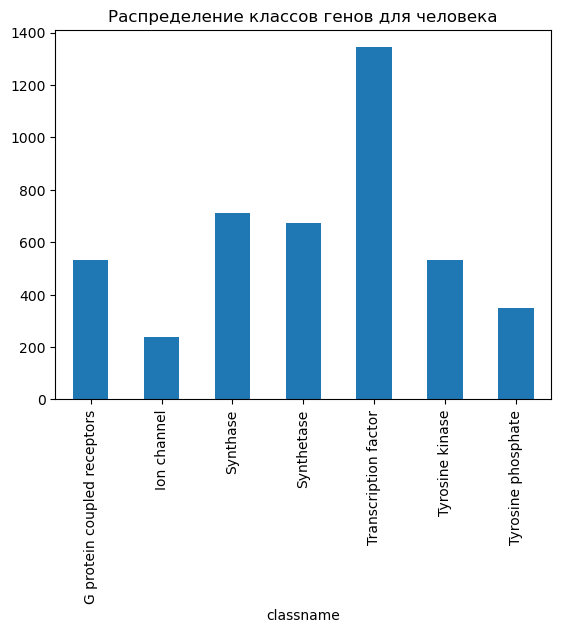

In [243]:
print('Число последовательностей каждого класса для человека')
print(dna_kaggle_human["classname"].value_counts())

dna_kaggle_human["classname"].value_counts().sort_index().plot.bar()
plt.title("Распределение классов генов для человека")

Число последовательностей каждого класса для шимпанезе
classname
Transcription factor           521
Synthase                       261
G protein coupled receptors    234
Synthetase                     228
Tyrosine kinase                185
Tyrosine phosphate             144
Ion channel                    109
Name: count, dtype: int64


Text(0.5, 1.0, 'Распределение классов генов для шимпанзе')

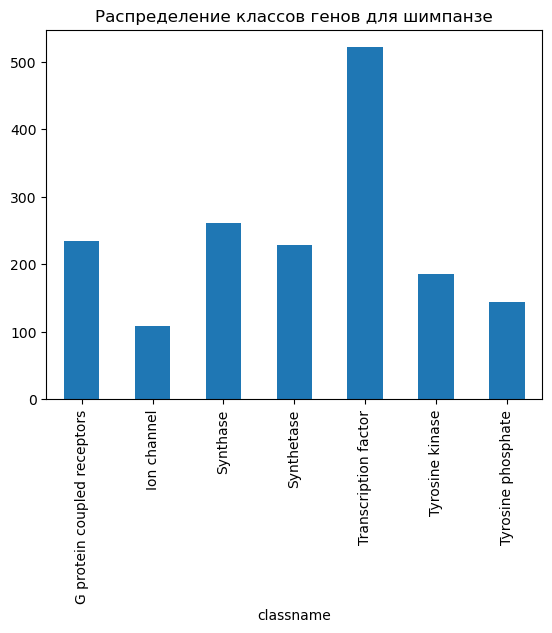

In [245]:
print('Число последовательностей каждого класса для шимпанезе')
print(dna_kaggle_monke["classname"].value_counts())

dna_kaggle_monke["classname"].value_counts().sort_index().plot.bar()
plt.title("Распределение классов генов для шимпанзе")

Число последовательностей каждого класса для собаки
classname
Transcription factor           260
Synthase                       135
G protein coupled receptors    131
Synthetase                      95
Tyrosine kinase                 75
Tyrosine phosphate              64
Ion channel                     60
Name: count, dtype: int64


Text(0.5, 1.0, 'Распределение классов генов для собаки')

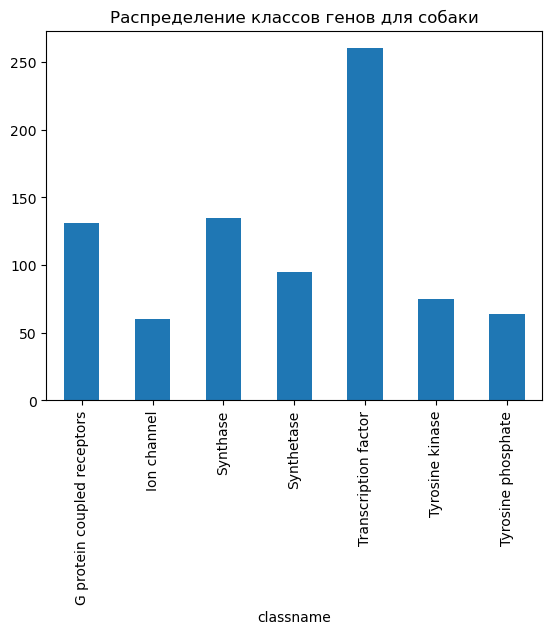

In [247]:
print('Число последовательностей каждого класса для собаки')
print(dna_kaggle_dog["classname"].value_counts())

dna_kaggle_dog["classname"].value_counts().sort_index().plot.bar()
plt.title("Распределение классов генов для собаки")